# Cauchy noise inference example

The Cauchy distribution (a Student-t with 1 degree of freedom) has fatter tails than the normal, meaning that it can be a better approximation to the noise process in some time series models; when there is a high degree of uncertainty regarding the underlying process, leading to a large standard deviation in a model's errors. This case study explains to the user the differences between the Cauchy and the more popular normal distribution and shows how to estimate a model with Cauchy errors in Pints.

Plot Cauchy probability density function versus a normal.

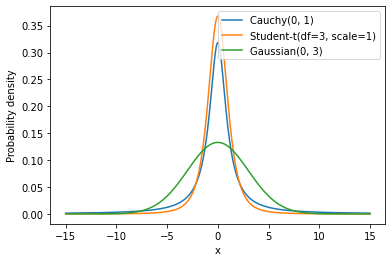

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

x = np.linspace(-15, 15, 1000)
y_c = scipy.stats.t.pdf(x, 1, loc=0, scale=1)
y_t = scipy.stats.t.pdf(x, 3, loc=0, scale=1)
y_norm = scipy.stats.norm.pdf(x, 0, 3)
plt.plot(x, y_c, label ='Cauchy(0, 1)')
plt.plot(x, y_t, label ='Student-t(df=3, scale=1)')
plt.plot(x, y_norm, label ='Gaussian(0, 3)')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend()
plt.show()

Compare a Cauchy error process with a normal error process for the logistic model.

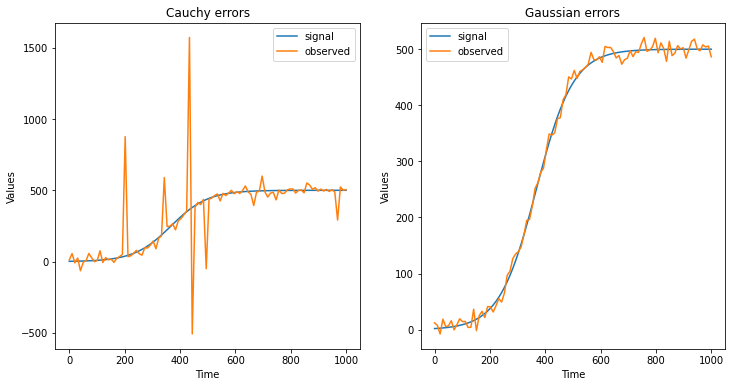

In [2]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add Cauchy noise
nu = 1
sigma = 10
observed_values_t = signal_values + scipy.stats.t.rvs(df=nu, loc=0, scale=sigma, size=signal_values.shape)
observed_values_norm = signal_values + scipy.stats.norm.rvs(loc=0, scale=sigma, size=signal_values.shape)
real_parameters = np.array(real_parameters + [sigma])

# Plot
fig = plt.figure(figsize=(12, 6)) 
plt.subplot(121)
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values_t,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Cauchy errors')
plt.legend()

plt.subplot(122)
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values_norm,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Gaussian errors')
plt.legend()
plt.show()

Specify a model using a Cauchy error process and use adaptive covariance to fit it to data.

Running...
Done!
param        mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-----------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
growth rate  0.01    0.00    0.01    0.01    0.01    0.01    0.02     1.01    217.44  216.86
capacity     499.77  2.59    494.35  498.12  499.94  501.57  504.75   1.02    295.51  294.72
sigma        11.59   1.59    8.75    10.49   11.52   12.57   15.04    1.01    258.47  257.78


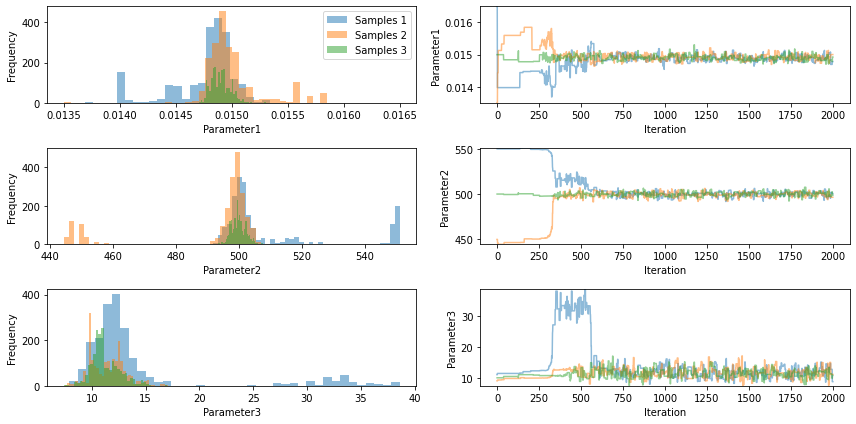

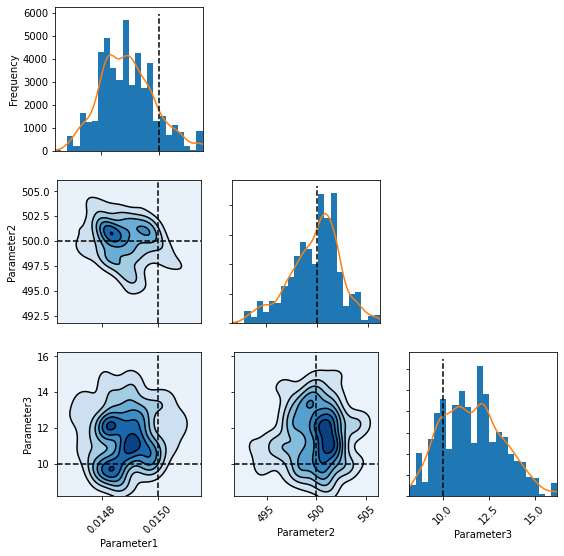

In [3]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values_t)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.CauchyLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, sigma*0.1],
    [0.02, 600, sigma*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.0,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(250)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 1000:, :]

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['growth rate', 'capacity', 'sigma'])
print(results)

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True, ref_parameters=real_parameters)

# Show graphs
plt.show()